c:\Users\USER\Documentos\Maestria\Deep_Learning\proyecto_dl\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


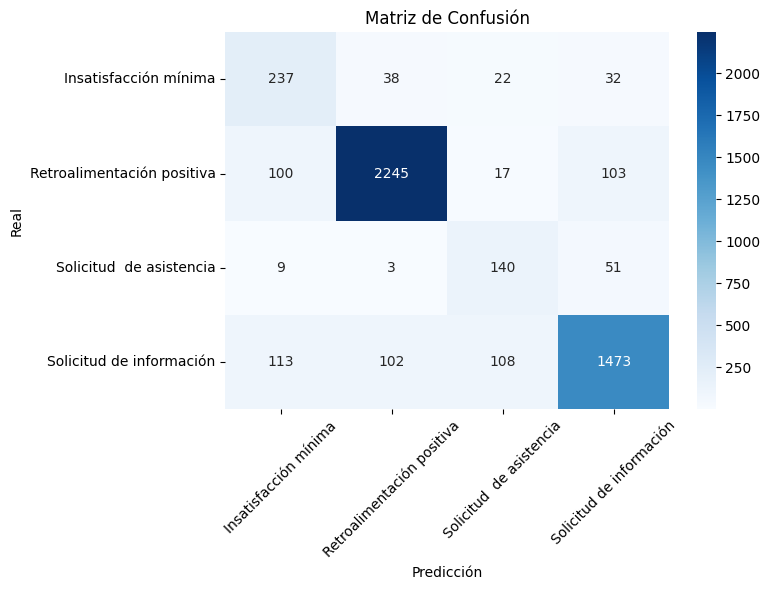

In [1]:
# ============================
# 1. IMPORTAR LIBRERÍAS
# ============================
import torch
import pickle
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from transformers import BertTokenizer, BertForSequenceClassification

# ============================
# 2. CARGAR ARCHIVOS DEL MODELO
# ============================
ROOT_DIR = Path("..").resolve()
MODEL_DIR = ROOT_DIR / "models"
DATA_DIR = ROOT_DIR / "data"
OUTPUT_DIR = ROOT_DIR / "outputs"

tokenizer = BertTokenizer.from_pretrained(str(MODEL_DIR / "tokenizer"), local_files_only=True)
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=4)
model.load_state_dict(torch.load(MODEL_DIR / "modelo_bert_finetuned.pth", map_location="cpu"))
model.eval()

with open(MODEL_DIR / "label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

# ============================
# 3. CARGAR Y PROCESAR DATASET DE PRUEBA
# ============================
df_test = pd.read_csv(DATA_DIR / "test_data.csv").dropna(subset=["Reporte"])
texts = df_test["Reporte"].astype(str).tolist()
true_labels = label_encoder.transform(df_test["Categoria"])

inputs = tokenizer(
    texts,
    truncation=True,
    padding="max_length",
    max_length=128,
    return_tensors="pt"
)

# ============================
# 4. PREDICCIÓN Y MÉTRICAS
# ============================
with torch.no_grad():
    outputs = model(**inputs)
    _, preds = torch.max(outputs.logits, dim=1)

y_true = true_labels
y_pred = preds.numpy()
class_names = label_encoder.classes_

report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")

metrics = {
    "accuracy": accuracy,
    "macro_f1": f1,
    "classes": [
        {
            "label": class_names[i],
            "precision": report[class_names[i]]["precision"],
            "recall": report[class_names[i]]["recall"],
            "f1_score": report[class_names[i]]["f1-score"]
        } for i in range(len(class_names))
    ]
}

OUTPUT_DIR.mkdir(exist_ok=True)

with open(OUTPUT_DIR / "metrics_report.json", "w") as f:
    json.dump(metrics, f, indent=2)

# ============================
# 5. MATRIZ DE CONFUSIÓN
# ============================
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "confusion_matrix.png")
plt.show()


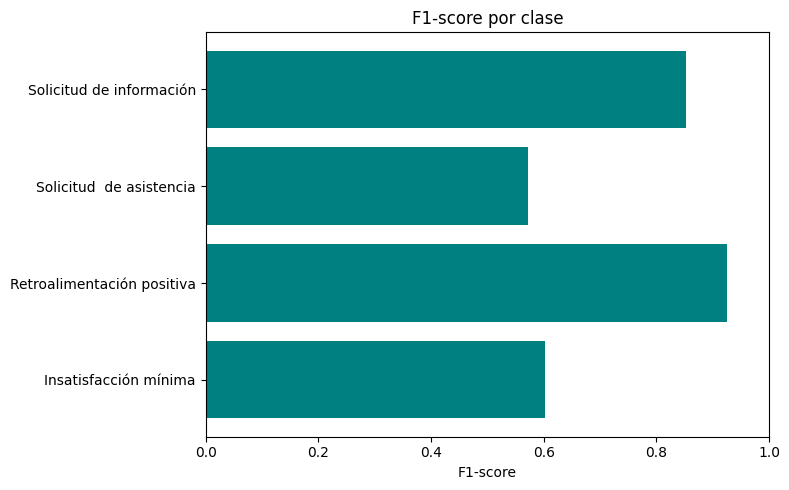

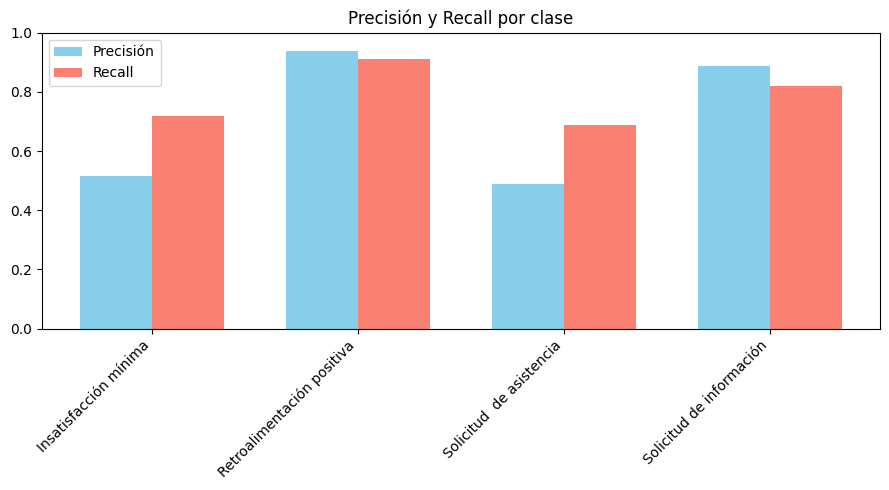

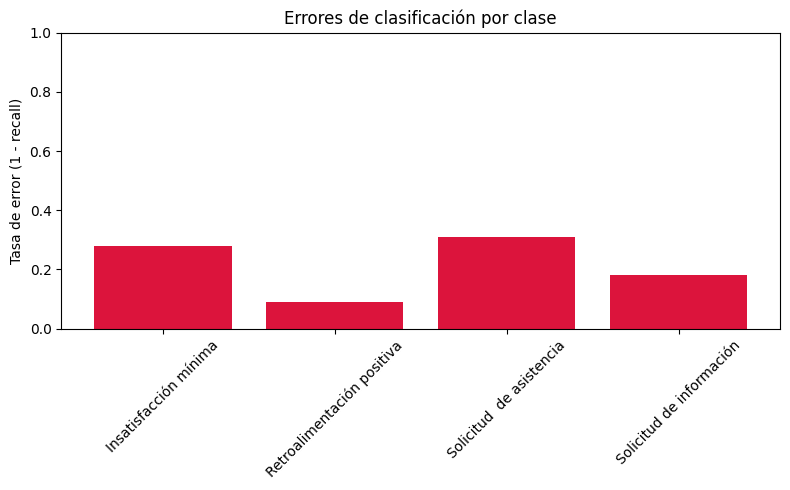

In [4]:
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# =============================
# 1. Cargar métricas desde archivo JSON
# =============================
OUTPUT_DIR = Path("..") / "outputs"

with open(OUTPUT_DIR / "metrics_report.json", "r") as f:
    metrics = json.load(f)

labels = [c["label"] for c in metrics["classes"]]
f1_scores = [c["f1_score"] for c in metrics["classes"]]
precisions = [c["precision"] for c in metrics["classes"]]
recalls = [c["recall"] for c in metrics["classes"]]
errors = [1 - r for r in recalls]

# =============================
# 2. Gráfico: F1-score por clase
# =============================
plt.figure(figsize=(8, 5))
plt.barh(labels, f1_scores, color='teal')
plt.xlabel("F1-score")
plt.title("F1-score por clase")
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "grafico_f1_score.png")
plt.show()

# =============================
# 3. Gráfico: Precisión vs Recall
# =============================
x = np.arange(len(labels))
width = 0.35
plt.figure(figsize=(9, 5))
plt.bar(x - width/2, precisions, width, label='Precisión', color='skyblue')
plt.bar(x + width/2, recalls, width, label='Recall', color='salmon')
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylim(0, 1)
plt.title("Precisión y Recall por clase")
plt.legend()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "grafico_precision_recall.png")
plt.show()

# =============================
# 4. Gráfico: Tasa de error por clase
# =============================
plt.figure(figsize=(8, 5))
plt.bar(labels, errors, color='crimson')
plt.ylabel("Tasa de error (1 - recall)")
plt.title("Errores de clasificación por clase")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "grafico_errores.png")
plt.show()

